In [1]:
import sympy
sympy.init_printing()

One thing Casadi is not good at currently is simplification, we rely on Sympy to check that the group is affine.

In [2]:
def g_sym(name):
    """define the matrix lie group, inherits product from matrix"""
    R = sympy.Matrix(sympy.symbols('R^{:s}_0:9'.format(name))).reshape(3, 3)
    v = sympy.Matrix(sympy.symbols('v^{:s}_0:3'.format(name))).reshape(3, 1)
    x = sympy.Matrix(sympy.symbols('x^{:s}_0:3'.format(name))).reshape(3, 1)
    X = sympy.Matrix.vstack(sympy.Matrix.hstack(R, v, x),
                        sympy.Matrix([0, 0, 0, 1, 0]).T,
                        sympy.Matrix([0, 0, 0, 0, 1]).T)
    return X

def g_from_elements(R, v, x):
    X = sympy.zeros(5, 5)
    X[0:3, 0:3] = R
    X[:3, 3] = v
    X[:3, 4] = x
    X[3, 3] = 1
    X[4, 4] = 1
    return X

def g_inv(X):
    R = X[0:3, 0:3]
    v = X[:3, 3]
    x = X[:3, 4]
    # this is a brute force inverse so we can
    # use this symbolicly for proofs, in actuality
    # the inverse is the transpose
    R_I = sympy.simplify(R.inv())
    return g_from_elements(R_I, -R_I*v, -R_I*x)

def skew(x):
    """skew matrix"""
    M = sympy.zeros(3, 3)
    M[0, 1] = -x[2]
    M[0, 2] = x[1]
    M[1, 0] = x[2]
    M[1, 2] = -x[0]
    M[2, 0] = -x[1]
    M[2, 1] = x[0]
    return M

def l(X, u):
    """define the derivative of the group"""
    g = sympy.Matrix(sympy.symbols('g_0:3'))
    R = X[0:3, 0:3]
    v = X[:3, 3]
    res = sympy.zeros(5, 5)
    res[:3, 3] = g
    res[:3, 4] = v
    return res

def r(X, u):
    """define the derivative of the group"""
    a = sympy.Matrix(u[0:3])
    R = X[0:3, 0:3]
    omega = sympy.Matrix(u[3:6])
    res = sympy.zeros(5, 5)
    res[:3, :3] = skew(omega)
    res[:3, 3] = a
    return res

def f2(X, u):
    """define the derivative of the group"""
    return l(X, u)*X + r(X, u)*X

def f(X, u):
    """define the derivative of the group"""
    R = X[0:3, 0:3]
    g = sympy.Matrix(sympy.symbols('g_0:3'))
    a = sympy.Matrix(u[0:3])
    omega = sympy.Matrix(u[3:6])
    v = X[:3, 3]
    x = X[:3, 4]
    dX = sympy.zeros(5, 5)
    dX[:3, :3] = R*skew(omega)
    #dX[:3, :3] = R # this is ok, still in lie algebra
    #dX[:3, :3] = skew(omega) # this fails, not in lie algebra
    #dX[:3, :3] = R + R # this is ok, still in lie algebra
    #dX[:3, :3] = sympy.eye(3) # this, fails, not in lie algebra

    # it is interesting to investigate what is still group
    # affine here, the requirement is that the derivative
    # must lie in the lie algebra and be a linear function of the state
    dX[:3, 3] = R*a + g
    # dX[:3, 3] = R*a + g + v # this is ok
    # dX[:3, 3] = R*a + g + sympy.Matrix.multiply_elementwise(v, v), this will fail v**2
    #dX[:3, 3] = R*a + g + R*v # this will fail, R*v both states
    #dX[:3, 3] = R*a + g + R*g # this is fine
    
    dX[:3, 4] = v
    #dX[:3, 4] = R*v # this will fail
    #dX[:3, 4] = R*a # this is fine
    return dX


a = sympy.Matrix(sympy.symbols('a_0:3'))
omega = sympy.Matrix(sympy.symbols('omega_0:3'))
u = sympy.Matrix.vstack(a, omega)
g_a = g_sym('a')
g_b = g_sym('b')
g_I = sympy.eye(5)
f(g_a, u)


def group_affine(f, g, verbose=False):
    res = sympy.simplify(f(g_a*g_b, u) - (f(g_a, u)*g_b + g_a*f(g_b, u) - g_a*f(g_I, u)*g_b))
    affine = sympy.Matrix.norm(res) == 0
    if verbose and not affine:
        print(res)
    return affine

In [3]:
group_affine(f, g_sym, verbose=True)

True

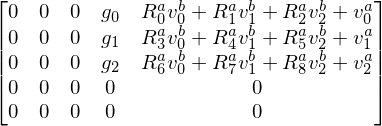

In [4]:
l(g_a*g_b, u)

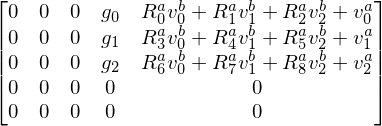

In [5]:
l(g_a, u) + g_a*(l(g_b, u) - l(g_I, u)*g_inv(g_a))

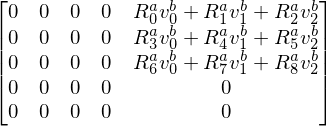

In [6]:
g_a*(l(g_b, u) - l(g_I, u)*g_inv(g_a))

Assuming you have an equation of the form:

$f(a) = l(a) a + ar$

The goup will still be invariant if:

$l(ab) = l(a) + a (l(b) - l(e)) a^{-1}$

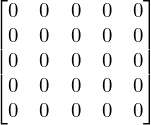

In [7]:
l(g_a*g_b, u) - (l(g_a, u) + g_a*l(g_b, u) - g_a*l(g_I, u))

The take away here, is that you can do anything you want in the tanget plane at the origin, if you are using left invaraint error, because both dynamics are impacted the same, since the rotation is zero. However, in the tangent plane after the rotation, if you have any non-constant dynamics, they will impact the error dynamics and the error equations will not be autonomous.